In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = 'cuda' if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [3]:
training_data = datasets.CIFAR10(root='data', train=True, download=True, transform=ToTensor(),)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor(),)
batch_size = 128

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim, g_map_dim, num_channel = 3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, g_map_dim*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(g_map_dim*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*8, g_map_dim*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_map_dim*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*4, g_map_dim*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(g_map_dim*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(g_map_dim*2, num_channel, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [6]:
z_dim = 100
g_map_dim = 64

In [7]:
gen = Generator(z_dim, g_map_dim)
gen.to(device)

gen.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, d_map_dim, num_channel = 3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channel, d_map_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim, d_map_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_map_dim*2),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim*2, d_map_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_map_dim*4),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(d_map_dim*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [9]:
d_map_dim = 64
disc = Discriminator(d_map_dim).to(device)

disc.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [10]:
lr = 2e-4
beta1 = 0.5

In [11]:
criterion = nn.BCELoss()

noise = torch.randn(64, z_dim,1, 1, device =device)

real_label = 1
fake_label = 0

optD = optim.Adam(disc.parameters(), lr = lr,  betas=(beta1, 0.999))
optG = optim.Adam(gen.parameters(), lr = lr,  betas=(beta1, 0.999))

In [12]:
epochs = 100
num = len(train_dataloader.dataset)//batch_size
gen_loss, disc_loss = [], []
for epoch in tqdm(range(epochs)):
    g, d = [], []
    for i, (X,y) in tqdm(enumerate(train_dataloader), total = num):
        X = X.to(device)
        disc.zero_grad()
        
        l = torch.full((X.shape[0], ), real_label, dtype = torch.float, device = device)
        output = disc(X).view(-1)
        loss_r = criterion(output, l)
        loss_r.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(X.shape[0], z_dim, 1, 1, device = device)
        fake = gen(noise)
        l.fill_(fake_label)
        output = disc(fake.detach()).view(-1)
        loss_f = criterion(output, l)
        loss_f.backward()
        
        optD.step()
        err_d = loss_r + loss_f
        d.append(err_d.item())
        
        gen.zero_grad()
        l.fill_(real_label)
        output = disc(fake).view(-1)
        l_g = criterion(output, l)
        l_g.backward()
        optG.step()
        g.append(l_g.item())
    gen_loss.append(sum(g)/num)
    disc_loss.append(sum(d)/num)
    
    print(f"[{epoch}] Generator Loss : {gen_loss[-1]:>.5f} Discriminator Loss : {disc_loss[-1]:>.5f}")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/390 [00:00<?, ?it/s]

[0] Generator Loss : 2.89957 Discriminator Loss : 0.81275


  0%|          | 0/390 [00:00<?, ?it/s]

[1] Generator Loss : 2.00139 Discriminator Loss : 0.97909


  0%|          | 0/390 [00:00<?, ?it/s]

[2] Generator Loss : 1.82095 Discriminator Loss : 1.03940


  0%|          | 0/390 [00:00<?, ?it/s]

[3] Generator Loss : 1.54015 Discriminator Loss : 1.11150


  0%|          | 0/390 [00:00<?, ?it/s]

[4] Generator Loss : 1.42046 Discriminator Loss : 1.10019


  0%|          | 0/390 [00:00<?, ?it/s]

[5] Generator Loss : 1.41612 Discriminator Loss : 1.10685


  0%|          | 0/390 [00:00<?, ?it/s]

[6] Generator Loss : 1.39630 Discriminator Loss : 1.11465


  0%|          | 0/390 [00:00<?, ?it/s]

[7] Generator Loss : 1.31086 Discriminator Loss : 1.14024


  0%|          | 0/390 [00:00<?, ?it/s]

[8] Generator Loss : 1.34522 Discriminator Loss : 1.10311


  0%|          | 0/390 [00:00<?, ?it/s]

[9] Generator Loss : 1.37041 Discriminator Loss : 1.10587


  0%|          | 0/390 [00:00<?, ?it/s]

[10] Generator Loss : 1.38710 Discriminator Loss : 1.11752


  0%|          | 0/390 [00:00<?, ?it/s]

[11] Generator Loss : 1.39699 Discriminator Loss : 1.10020


  0%|          | 0/390 [00:00<?, ?it/s]

[12] Generator Loss : 1.40320 Discriminator Loss : 1.09982


  0%|          | 0/390 [00:00<?, ?it/s]

[13] Generator Loss : 1.42136 Discriminator Loss : 1.09542


  0%|          | 0/390 [00:00<?, ?it/s]

[14] Generator Loss : 1.40342 Discriminator Loss : 1.11561


  0%|          | 0/390 [00:00<?, ?it/s]

[15] Generator Loss : 1.40169 Discriminator Loss : 1.10430


  0%|          | 0/390 [00:00<?, ?it/s]

[16] Generator Loss : 1.39237 Discriminator Loss : 1.10008


  0%|          | 0/390 [00:00<?, ?it/s]

[17] Generator Loss : 1.39162 Discriminator Loss : 1.09415


  0%|          | 0/390 [00:00<?, ?it/s]

[18] Generator Loss : 1.40532 Discriminator Loss : 1.09903


  0%|          | 0/390 [00:00<?, ?it/s]

[19] Generator Loss : 1.43175 Discriminator Loss : 1.08992


  0%|          | 0/390 [00:00<?, ?it/s]

[20] Generator Loss : 1.43061 Discriminator Loss : 1.08607


  0%|          | 0/390 [00:00<?, ?it/s]

[21] Generator Loss : 1.42647 Discriminator Loss : 1.07437


  0%|          | 0/390 [00:00<?, ?it/s]

[22] Generator Loss : 1.44825 Discriminator Loss : 1.05704


  0%|          | 0/390 [00:00<?, ?it/s]

[23] Generator Loss : 1.45146 Discriminator Loss : 1.05610


  0%|          | 0/390 [00:00<?, ?it/s]

[24] Generator Loss : 1.46571 Discriminator Loss : 1.04577


  0%|          | 0/390 [00:00<?, ?it/s]

[25] Generator Loss : 1.47487 Discriminator Loss : 1.04762


  0%|          | 0/390 [00:00<?, ?it/s]

[26] Generator Loss : 1.49898 Discriminator Loss : 1.02914


  0%|          | 0/390 [00:00<?, ?it/s]

[27] Generator Loss : 1.51504 Discriminator Loss : 1.05326


  0%|          | 0/390 [00:00<?, ?it/s]

[28] Generator Loss : 1.50734 Discriminator Loss : 0.99081


  0%|          | 0/390 [00:00<?, ?it/s]

[29] Generator Loss : 1.56014 Discriminator Loss : 0.98827


  0%|          | 0/390 [00:00<?, ?it/s]

[30] Generator Loss : 1.57232 Discriminator Loss : 1.01619


  0%|          | 0/390 [00:00<?, ?it/s]

[31] Generator Loss : 1.53789 Discriminator Loss : 0.97182


  0%|          | 0/390 [00:00<?, ?it/s]

[32] Generator Loss : 1.59502 Discriminator Loss : 1.00317


  0%|          | 0/390 [00:00<?, ?it/s]

[33] Generator Loss : 1.58920 Discriminator Loss : 0.91874


  0%|          | 0/390 [00:00<?, ?it/s]

[34] Generator Loss : 1.63932 Discriminator Loss : 0.97706


  0%|          | 0/390 [00:00<?, ?it/s]

[35] Generator Loss : 1.63727 Discriminator Loss : 0.91210


  0%|          | 0/390 [00:00<?, ?it/s]

[36] Generator Loss : 1.68310 Discriminator Loss : 0.91310


  0%|          | 0/390 [00:00<?, ?it/s]

[37] Generator Loss : 1.62783 Discriminator Loss : 1.00447


  0%|          | 0/390 [00:00<?, ?it/s]

[38] Generator Loss : 1.69848 Discriminator Loss : 0.87463


  0%|          | 0/390 [00:00<?, ?it/s]

[39] Generator Loss : 1.73087 Discriminator Loss : 0.87820


  0%|          | 0/390 [00:00<?, ?it/s]

[40] Generator Loss : 1.74355 Discriminator Loss : 0.88253


  0%|          | 0/390 [00:00<?, ?it/s]

[41] Generator Loss : 1.75932 Discriminator Loss : 0.91923


  0%|          | 0/390 [00:00<?, ?it/s]

[42] Generator Loss : 1.80670 Discriminator Loss : 0.82770


  0%|          | 0/390 [00:00<?, ?it/s]

[43] Generator Loss : 1.84344 Discriminator Loss : 0.84025


  0%|          | 0/390 [00:00<?, ?it/s]

[44] Generator Loss : 1.84346 Discriminator Loss : 0.83360


  0%|          | 0/390 [00:00<?, ?it/s]

[45] Generator Loss : 1.81411 Discriminator Loss : 0.92075


  0%|          | 0/390 [00:00<?, ?it/s]

[46] Generator Loss : 1.85022 Discriminator Loss : 0.80804


  0%|          | 0/390 [00:00<?, ?it/s]

[47] Generator Loss : 1.90487 Discriminator Loss : 0.80131


  0%|          | 0/390 [00:00<?, ?it/s]

[48] Generator Loss : 1.92208 Discriminator Loss : 0.78771


  0%|          | 0/390 [00:00<?, ?it/s]

[49] Generator Loss : 1.96882 Discriminator Loss : 0.78141


  0%|          | 0/390 [00:00<?, ?it/s]

[50] Generator Loss : 1.97026 Discriminator Loss : 0.83761


  0%|          | 0/390 [00:00<?, ?it/s]

[51] Generator Loss : 1.96141 Discriminator Loss : 0.78217


  0%|          | 0/390 [00:00<?, ?it/s]

[52] Generator Loss : 1.99890 Discriminator Loss : 0.82460


  0%|          | 0/390 [00:00<?, ?it/s]

[53] Generator Loss : 2.00646 Discriminator Loss : 0.72786


  0%|          | 0/390 [00:00<?, ?it/s]

[54] Generator Loss : 2.05005 Discriminator Loss : 0.74928


  0%|          | 0/390 [00:00<?, ?it/s]

[55] Generator Loss : 2.09487 Discriminator Loss : 0.83506


  0%|          | 0/390 [00:00<?, ?it/s]

[56] Generator Loss : 1.93967 Discriminator Loss : 0.81565


  0%|          | 0/390 [00:00<?, ?it/s]

[57] Generator Loss : 1.98658 Discriminator Loss : 0.86855


  0%|          | 0/390 [00:00<?, ?it/s]

[58] Generator Loss : 2.06743 Discriminator Loss : 0.67668


  0%|          | 0/390 [00:00<?, ?it/s]

[59] Generator Loss : 2.09483 Discriminator Loss : 0.73724


  0%|          | 0/390 [00:00<?, ?it/s]

[60] Generator Loss : 2.12410 Discriminator Loss : 0.70035


  0%|          | 0/390 [00:00<?, ?it/s]

[61] Generator Loss : 2.18033 Discriminator Loss : 0.70268


  0%|          | 0/390 [00:00<?, ?it/s]

[62] Generator Loss : 2.20486 Discriminator Loss : 0.67997


  0%|          | 0/390 [00:00<?, ?it/s]

[63] Generator Loss : 2.15478 Discriminator Loss : 0.82561


  0%|          | 0/390 [00:00<?, ?it/s]

[64] Generator Loss : 2.22630 Discriminator Loss : 0.65194


  0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

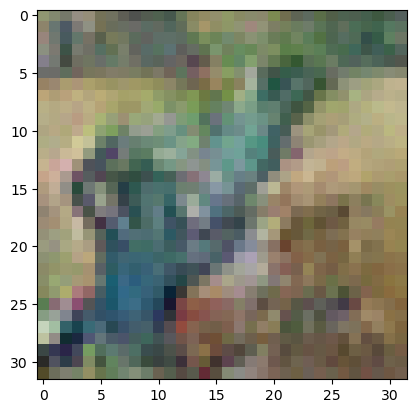

In [13]:
with torch.no_grad():
    fake = gen(torch.randn(10, z_dim, 1, 1, device=device)).detach().cpu()
    fake = np.transpose(fake.numpy(), (0, 2, 3, 1))
    plt.imshow(fake[0])